In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import matplotlib.pyplot as plt

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
open_path = '/content/drive/MyDrive/FYP/Stock Market Group/Result Analysis/Results/DataSet for 20 /AAPL_5_min_tops_with_20_indicators_3.csv'

In [23]:
df_tops = pd.read_csv(open_path)

In [24]:
closed_prices = df_tops.iloc[:,0]

In [25]:
df_xgboost_preds = pd.read_csv('/content/drive/MyDrive/FYP/Stock Market Group/Result Analysis/Results/DataSet for 20 /AAPL_XGBOOST_predictions_20_indicators.csv')

In [31]:
df_xgboost_preds.head()

,close_prices,predicted,actual
0,182.570099,0,0
1,182.429993,0,0
2,182.529999,0,0
3,182.521194,0,0
4,182.585007,0,0


In [26]:
len(df_xgboost_preds)

2390

In [58]:
def profit_calculation(df_preds):
  def plot_results(min_points_df, trades, title):
    # profit graph
    start_range = 0
    end_range = 1000
    df_plot = min_points_df[start_range:end_range]
    df_tops_plot = df_preds[start_range:end_range]

    indices_of_bottoms = df_plot.index[df_plot['min_points'] == 1].tolist()
    indices_of_tops = df_plot.index[df_plot['top_points'] == 1].tolist()

    plt.figure(figsize=(15, 6))
    # Plot Close_Price
    plt.plot(df_plot['close_prices'], label='Close Price', linestyle='--', c='grey')

    # Track if label is added
    profit_label = False
    loss_label = False

    for trade in trades:
        if trade[0] < end_range:
            profit_range = df_plot[trade[0]:trade[1]]
            if trade[-1] > 0:
                plt.plot(profit_range['close_prices'], linestyle='-', c='green', label='Profit Trade' if not profit_label else None)
                profit_label = True
            else:
                plt.plot(profit_range['close_prices'], linestyle='-', c='red', label='Loss Trade' if not loss_label else None)
                loss_label = True
        else:
            break

    # Mark points where 'Target_Value' is 1 with a different color
    plt.scatter(indices_of_bottoms, df_plot.loc[indices_of_bottoms, 'close_prices'], c='red', label='Bottom point', marker='^', s=30)
    plt.scatter(indices_of_tops, df_tops_plot.loc[indices_of_tops, 'close_prices'], c='blue', label='Top point', marker='v', s=30)

    # Add labels and legend
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()
  def calculate_perfect_profit(df_preds):
    top_indices = df_preds[df_preds['actual'] == 1].index
    min_close_prices = []
    min_close_prices_indices = []
    min_close_price = df_preds.loc[0:top_indices[0]-1, 'close_prices'].min()
    min_close_prices.append(min_close_price)
    min_close_index = df_preds.loc[0:top_indices[0]-1, 'close_prices'].idxmin()
    min_close_prices_indices.append(min_close_index)
    for i in range(len(top_indices) - 1):
        start_idx = top_indices[i]
        end_idx = top_indices[i + 1]
        # Get the minimum close price within this range
        min_close_price = df_preds.loc[start_idx:end_idx-1, 'close_prices'].min()
        min_close_prices.append(min_close_price)

        # Get the index of the maximum close price
        min_close_index = df_preds.loc[start_idx:end_idx-1, 'close_prices'].idxmin()
        min_close_prices_indices.append(min_close_index)
    total_profit = 0
    trades = []
    for i in range(len(top_indices)):
      total_profit += df_preds.loc[top_indices[i], 'close_prices'] - df_preds.loc[min_close_prices_indices[i], 'close_prices']
      trades.append([min_close_prices_indices[i], top_indices[i], df_preds.loc[min_close_prices_indices[i], 'close_prices'], df_preds.loc[top_indices[i], 'close_prices']])
    print("Total perfect profit:", total_profit, "$")
    min_points = [0] *len(df_preds)
    for i in min_close_prices_indices:
      min_points[i] = 1
    data = {'close_prices': df_preds.iloc[:,0], 'min_points': min_points, 'top_points': df_preds.iloc[:,2]}
    min_points_df = pd.DataFrame(data, columns=['close_prices', 'min_points', 'top_points'])
    return trades, min_points_df, total_profit
  def calculate_real_profit(df_preds, min_points_df, print_every_trade=False):
    trade_started = False
    entering_price = 0
    exit_price = 0
    entering_idx = 0
    exit_idx = 0
    total_real_profit = 0
    real_trades = []
    for i in range(len(df_preds)):
      if (min_points_df.iloc[i,1] == 1) and not(trade_started):
        trade_started = True
        entering_price = df_preds.iloc[i,0]
        entering_idx = i
      if (df_preds.iloc[i,1] == 1) and trade_started:
        trade_started = False
        exit_price = df_preds.iloc[i,0]
        exit_idx = i
        profit = exit_price - entering_price
        real_trades.append([entering_idx, exit_idx, entering_price, exit_price, profit])
        if(print_every_trade):
          print("Entering trade price : ", entering_price,"$")
          print("Exiting trade price : ", exit_price,"$")
          print("Profit from the trade:", profit,"$")
        total_real_profit += profit
    print("Total real profit:", total_real_profit,"$")
    data = {'close_prices': df_preds.iloc[:,0], 'min_points': min_points_df.iloc[:,1], 'top_points': df_preds.iloc[:,1]}
    predicted_df = pd.DataFrame(data, columns=['close_prices', 'min_points', 'top_points'])
    return real_trades, predicted_df, total_real_profit

  perfect_trades, min_points_df, perfect_profit = calculate_perfect_profit(df_preds)
  real_trades, predicted_df, real_profit = calculate_real_profit(df_preds, min_points_df,False)
  print("Percentage of profit earned:", round(real_profit/perfect_profit, 4)* 100,"\b%")
  plot_results(min_points_df, perfect_trades, "Perfect trades")
  plot_results(predicted_df, real_trades, "Real trades")
  return perfect_trades, real_trades



Total perfect profit: 71.31588745117179 $
Total real profit: 42.15710449218756 $
Percentage of profit earned: 59.11 %


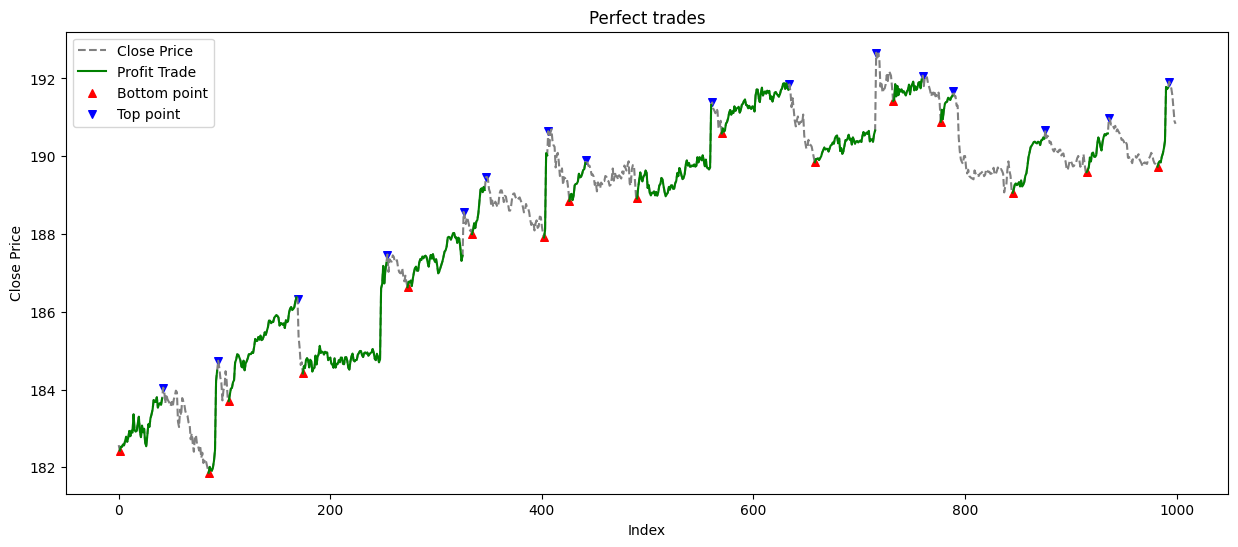

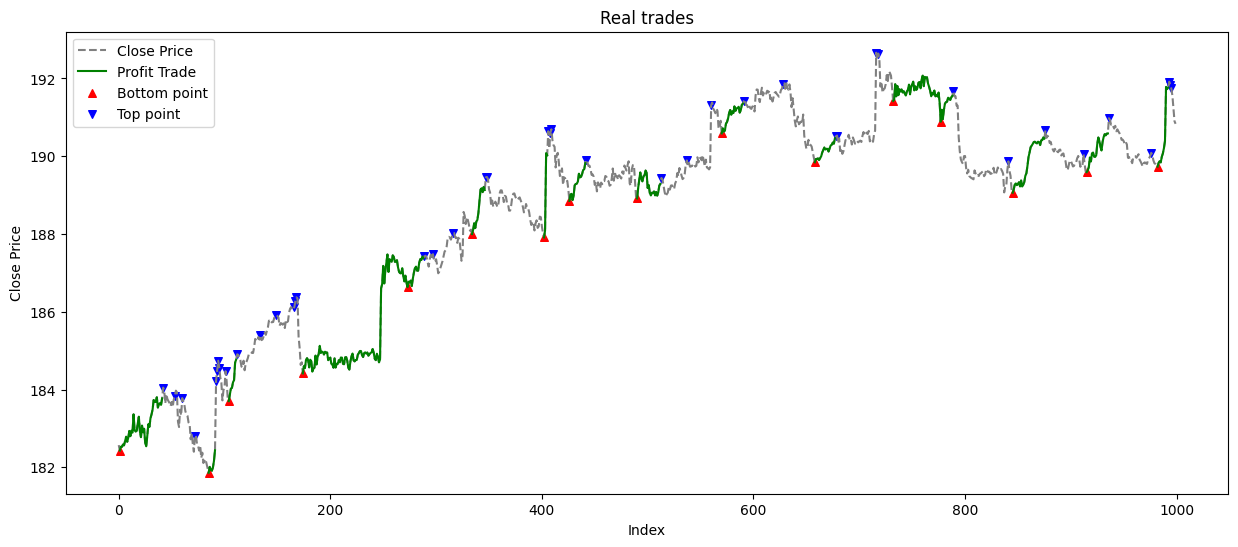

In [59]:
perfect_trades, real_trades = profit_calculation(df_xgboost_preds)